This notebook contain code to compare selection across 3 populations using 1000 Genomes data (plot scatterplots to compare selection between populations, calculates and writes differential selection scores to file)

In [15]:
#https://www.kite.com/python/answers/how-to-plot-a-linear-regression-line-on-a-scatter-plot-in-python
%pylab inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from heapq import nlargest
from operator import itemgetter 
import copy

Populating the interactive namespace from numpy and matplotlib


/storage/BonnieH/anaconda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [16]:
# Function to plot scatterplot of the posterior estimate of s for each locus (Pairwise comparisons of SISTR scores)
def plot(color_list, size_list, overlap, diff_sel, diff_opt,svals1, svals2,  fig_num, pop1, pop2):
    fig = plt.figure(fig_num)
    print('Number of loci with non-overlapping 95% CI: ' + str(overlap.count('N')))
    print('Number of loci with only one locus under selection: ' + str(diff_sel.count('Y')))
    #print('Number of loci with different optimal allele: ' + str(diff_opt.count('Y')))
    svals1_edited = [10**-5.1 if x==0 else x for x in svals1]
    svals2_edited = [10**-5.1 if x==0 else x for x in svals2]
    plt.scatter(svals1_edited, svals2_edited, s=size_list, c=color_list)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(10**-5.2,0.3)
    plt.ylim(10**-5.2,0.3)
    plt.plot([10**-5.2,0.3],[10**-5.2,0.3],c='black')
    plt.xlabel(pop1 + ' s value')
    plt.ylabel(pop2 + ' s value')
    plt.title(pop1 + ' v. ' + pop2 + ' %d loci with non-overlapping 95 percent CI \n %d loci with only one locus under selection'%(overlap.count('N'), diff_sel.count('Y'))) #\n %d/%d loci different opt allele diff_opt.count('Y'), diff_sel.count('Y')

In [17]:
def checkOverlap(interval1, interval2):
    interval1 = interval1[:-1]
    interval1 = interval1[1:]
    interval1 = interval1.split(',')
    interval2 = interval2[:-1]
    interval2 = interval2[1:]
    interval2 = interval2.split(',')
    
    x1 = float(interval1[0])
    x2 = float(interval1[1])
    y1 = float(interval2[0])
    y2 = float(interval2[1])
    
    if (x1 >= y1 and x1 <= y2) or (x2 >= y1 and x2 <= y2) or (y1 >= x1 and y1 <= x2) or (y2 >= x1 and y2 <= x2):
        return True, min(abs(y1-x2), abs(y2-x1))
    else:
        return False, min(abs(y1-x2), abs(y2-x1))

In [18]:
def checkDiffSel(pval1, pval2):
    
    if pval1 < 0.001 and pval2 > 0.2:
        return True
    if pval1 > 0.2 and pval2 < 0.001:
        return True
    else:
        return False

In [19]:
def checkOptDiff(per, opt1, opt2):
    if opt1 != opt2:
        if per == 2:
            if opt1 < 20 or opt2 < 20: 
                return True
                
        if per == 3:
            if opt1 < 13 or opt2 < 13:
                return True
                
        if per == 4:
            if opt1 < 10 or opt2 < 10 :
                return True
            
    return False

In [20]:
def getNumNonOverlap(ci1, ci2, svals1, svals2, pvals1, pvals2, opt1, opt2, default_color, non_default_color, default_size, non_default_size, chrom_list, start_list, top_n):
    
    color_list = []
    size_list = []
    overlap = []
    diff_sel = []
    diff_score_med = []
    diff_score_ci = []
    diff_opt = []
    
    for i in range(0, len(ci1)):
        
        result, ci_diff = checkOverlap(ci1[i], ci2[i])
        if result == False:
            overlap.append('N')
        else:
            overlap.append('Y')
            
        if checkDiffSel(pvals1[i], pvals2[i]) == True:
            diff_sel.append('Y')
            color_list.append(non_default_color)
            size_list.append(non_default_size)
        else:
            diff_sel.append('N')
            color_list.append(default_color)
            size_list.append(default_size)
            
        if checkOptDiff(per_list[i],opt1[i],opt2[i]) == True:
            diff_opt.append('Y')
        else:
            diff_opt.append('N')
        
        if result == True:
            diff_score_ci.append(0)
        else:
            diff_score_ci.append(ci_diff)
        diff_score_med.append(abs(svals1[i] - svals2[i]))
        
    diff_score_med_copy = copy.deepcopy(diff_score_med)
    
    for i in range(0, len(diff_sel)):
        if diff_sel[i] == 'N':
            diff_score_med_copy[i] = 0
    
    top_indices = sorted(range(len(diff_score_med_copy)), key=lambda x: diff_score_med_copy[x], reverse=True)[:top_n]
    
    for elem in top_indices:
        color_list[elem] = 'blue'
        size_list[elem] = 5
        
    return color_list, size_list, overlap, diff_sel, diff_score_med, diff_score_ci, diff_opt 

In [21]:
# Process files
CEU_df = pd.read_csv('CEU_final.txt', sep='\t')
YRI_df = pd.read_csv('YRI_final.txt', sep='\t')
CHB_df = pd.read_csv('CHB_final.txt', sep='\t')

chrom_list = list(CEU_df['chrom'])
start_list = list(CEU_df['start'])
end_list = list(CEU_df['end'])
per_list = list(CEU_df['period'])
motif_list = list(CEU_df['motif'])
coding_list = list(CEU_df['coding'])
intron_list = list(CEU_df['intron'])
utr5_list = list(CEU_df['UTR5'])
utr3_list = list(CEU_df['UTR3'])
promoter_list = list(CEU_df['promoter5kb'])
intergenic_list = list(CEU_df['intergenic'])

opt_CEU = list(CEU_df['optimal_ru'])
opt_YRI = list(YRI_df['optimal_ru'])
opt_CHB = list(CHB_df['optimal_ru'])

svals_CEU = list(CEU_df['ABC_s_median'])
svals_YRI = list(YRI_df['ABC_s_median'])
svals_CHB = list(CHB_df['ABC_s_median'])

conf_int_CEU = list(CEU_df['ABC_s_95%_CI'])
conf_int_YRI = list(YRI_df['ABC_s_95%_CI'])
conf_int_CHB = list(CHB_df['ABC_s_95%_CI'])

pvals_CEU = list(CEU_df['LRT_p_value'])
pvals_YRI = list(YRI_df['LRT_p_value'])
pvals_CHB = list(CHB_df['LRT_p_value'])

#svals_CEU_edited = [10**-5.1 if x==0 else x for x in svals_CEU]
#svals_YRI_edited = [10**-5.1 if x==0 else x for x in svals_YRI]
#svals_CHB_edited = [10**-5.1 if x==0 else x for x in svals_CHB]

to_remove = []
for i in range(0, len(svals_CEU)):
    if np.isnan(svals_CEU[i]) == True or np.isnan(svals_CHB[i]) == True or np.isnan(svals_YRI[i]) == True: 
        to_remove.append(i)
        
print('Number of loci before removing N/A: ' + str(len(svals_CEU)))

for index in sorted(to_remove, reverse=True):
    del svals_CEU[index]
    del svals_YRI[index]
    del svals_CHB[index]
    del conf_int_CEU[index]
    del conf_int_YRI[index]
    del conf_int_CHB[index]
    del pvals_CEU[index]
    del pvals_YRI[index]
    del pvals_CHB[index]
    del chrom_list[index]
    del start_list[index]
    del end_list[index]
    del per_list[index]
    del motif_list[index]
    del opt_CEU[index]
    del opt_YRI[index]
    del opt_CHB[index]
    del coding_list[index] 
    del intron_list[index] 
    del utr5_list[index]
    del utr3_list[index] 
    del promoter_list[index] 
    del intergenic_list[index]
    
print('Number of loci after removing N/A: ' + str(len(conf_int_CHB)))

Number of loci before removing N/A: 87040
Number of loci after removing N/A: 79740


In [22]:
default_color = 'green'
non_default_color = 'red'
default_size = 0.2
non_default_size = 2
top_n = 50

Number of loci with non-overlapping 95% CI: 2424
Number of loci with only one locus under selection: 2012


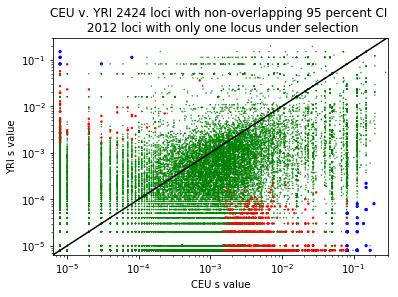

In [23]:
color_list, size_list, overlap, diff_sel, diff_score_med, diff_score_ci, diff_opt = getNumNonOverlap(conf_int_CEU, conf_int_YRI, svals_CEU, svals_YRI, pvals_CEU, pvals_YRI, opt_CEU, opt_YRI, default_color, non_default_color, default_size, non_default_size,  chrom_list, start_list, top_n)
fig_num = 1
pop1 = 'CEU'
pop2 = 'YRI'
plot(color_list, size_list, overlap, diff_sel, diff_opt, svals_CEU, svals_YRI, fig_num, pop1, pop2)

In [24]:
#Write results to file CEU/YRI

df = pd.DataFrame()
df['chrom'] = chrom_list
df['start'] = start_list
df['end'] = end_list
df['period'] = per_list
df['motif'] = motif_list
df['CEU_optimal_ru'] = opt_CEU
df['YRI_optimal_ru'] = opt_YRI
df['CEU_s_val'] = svals_CEU
df['YRI_s_val'] = svals_YRI
df['CEU_95%_CI'] = conf_int_CEU
df['YRI_95%_CI'] = conf_int_YRI
df['CEU_p_val'] = pvals_CEU
df['YRI_p_val'] = pvals_YRI
df['diff_score_med'] = diff_score_med
df['diff_score_ci'] = diff_score_ci
df['ci_overlap'] = overlap
df['diff_opt'] = diff_opt
df['diff_selection'] = diff_sel
'''
df['coding'] = coding_list
df['intron'] = intron_list 
df['utr5'] = utr5_list
df['utr3'] = utr3_list 
df['promoter'] = promoter_list
df['intergenic'] = intergenic_list
'''
df = df.sort_values(by=['diff_score_med'], ascending=False)
#df.to_csv('diff_scores_CEU_YRI_annot.txt', sep = '\t', index=False)
df.head(50)

,chrom,start,end,period,motif,CEU_optimal_ru,YRI_optimal_ru,CEU_s_val,YRI_s_val,CEU_95%_CI,YRI_95%_CI,CEU_p_val,YRI_p_val,diff_score_med,diff_score_ci,ci_overlap,diff_opt,diff_selection
6733,1,242041383,242041413,3,AAT,11,11,0.32235,0.01238,"(0.118,0.92487)","(0.0065,0.0244)",0.000359,0.000055,0.30997,0.09360,N,N,N
18021,3,150530784,150530817,3,AAT,11,11,0.32235,0.04780,"(0.118,0.92487)","(0.02414,0.12438)",0.000359,0.000074,0.27455,0.00000,Y,N,N
57088,12,95298124,95298154,3,AAT,10,10,0.27976,0.05358,"(0.08436,0.8276)","(0.0233,0.16716)",0.000193,0.000081,0.22618,0.00000,Y,N,N
79194,22,33288949,33288976,3,AAT,9,9,0.19851,0.00255,"(0.05275,0.76466)","(0,0.00627)",0.000100,0.001303,0.19596,0.04648,N,N,N
36686,7,75960293,75960320,3,AAT,9,9,0.19851,0.00335,"(0.05275,0.76466)","(0.00026,0.0075)",0.000100,0.000440,0.19516,0.04525,N,N,N
44421,9,36115316,36115343,3,AAT,9,9,0.19851,0.00408,"(0.05275,0.76466)","(0.00069,0.00913)",0.000100,0.000278,0.19443,0.04362,N,N,N
69881,17,37900522,37900558,4,AAAT,9,9,0.19276,0.00008,"(0.0468,0.78494)","(0,0.00184)",0.000094,0.221850,0.19268,0.04496,N,N,Y
78538,21,42042330,42042357,3,AAT,9,9,0.19851,0.00588,"(0.05275,0.76466)","(0.00202,0.01298)",0.000100,0.000063,0.19263,0.03977,N,N,N
44358,9,34642012,34642039,3,AAT,9,9,0.00694,0.19851,"(0.00233,0.01543)","(0.05275,0.76466)",0.000060,0.000100,0.19157,0.03732,N,N,N
61423,14,29281134,29281161,3,AAT,9,9,0.19851,0.00701,"(0.05275,0.76466)","(0.00242,0.01543)",0.000100,0.000060,0.19150,0.03732,N,N,N


Number of loci with non-overlapping 95% CI: 1305
Number of loci with only one locus under selection: 1036


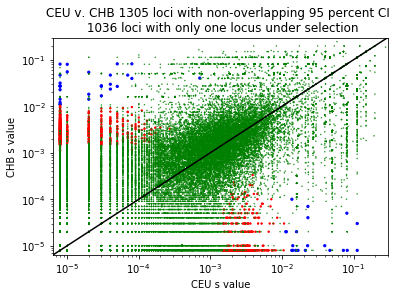

In [25]:
color_list, size_list, overlap, diff_sel, diff_score_med, diff_score_ci, diff_opt = getNumNonOverlap(conf_int_CEU, conf_int_CHB, svals_CEU, svals_CHB, pvals_CEU, pvals_CHB, opt_CEU, opt_CHB, default_color, non_default_color, default_size, non_default_size, chrom_list, start_list, top_n)
fig_num = 2
pop1 = 'CEU'
pop2 = 'CHB'
plot(color_list, size_list, overlap, diff_sel, diff_opt, svals_CEU, svals_CHB, fig_num, pop1, pop2)

In [26]:
#Write results to file CEU/CHB

df = pd.DataFrame()
df['chrom'] = chrom_list
df['start'] = start_list
df['end'] = end_list
df['period'] = per_list
df['motif'] = motif_list
df['CEU_optimal_ru'] = opt_CEU
df['CHB_optimal_ru'] = opt_CHB
df['CEU_s_val'] = svals_CEU
df['CHB_s_val'] = svals_CHB
df['CEU_95%_CI'] = conf_int_CEU
df['CHB_95%_CI'] = conf_int_CHB
df['CEU_p_val'] = pvals_CEU
df['CHB_p_val'] = pvals_CHB
df['diff_score_med'] = diff_score_med
df['diff_score_ci'] = diff_score_ci
df['ci_overlap'] = overlap
df['diff_opt'] = diff_opt
df['diff_selection'] = diff_sel
'''
df['coding'] = coding_list
df['intron'] = intron_list 
df['utr5'] = utr5_list
df['utr3'] = utr3_list 
df['promoter'] = promoter_list
df['intergenic'] = intergenic_list
'''
#df.to_csv('diff_scores_CEU_CHB_annot.txt', sep = '\t', index=False)
df = df.sort_values(by=['diff_score_med'], ascending=False)
df.head(50)


,chrom,start,end,period,motif,CEU_optimal_ru,CHB_optimal_ru,CEU_s_val,CHB_s_val,CEU_95%_CI,CHB_95%_CI,CEU_p_val,CHB_p_val,diff_score_med,diff_score_ci,ci_overlap,diff_opt,diff_selection
76600,20,31512823,31512850,3,AAT,9,9,0.00402,0.19851,"(0.00067,0.00872)","(0.05275,0.76466)",0.000289,0.000100,0.19449,0.04403,N,N,N
13358,2,224796047,224796074,3,AAT,9,9,0.19851,0.00543,"(0.05275,0.76466)","(0.00175,0.01231)",0.000100,0.000142,0.19308,0.04044,N,N,N
44262,9,31749577,31749604,3,AAT,9,9,0.19851,0.00558,"(0.05275,0.76466)","(0.00162,0.01264)",0.000100,0.000068,0.19293,0.04011,N,N,N
28899,5,157060219,157060246,3,AAT,9,9,0.19851,0.00719,"(0.05275,0.76466)","(0.00251,0.01543)",0.000100,0.000062,0.19132,0.03732,N,N,N
69881,17,37900522,37900558,4,AAAT,9,9,0.19276,0.00231,"(0.0468,0.78494)","(0,0.00577)",0.000094,0.001928,0.19045,0.04103,N,N,N
23148,4,136196011,136196038,3,AAT,9,9,0.00836,0.19851,"(0.00302,0.02081)","(0.05275,0.76466)",0.000061,0.000100,0.19015,0.03194,N,N,N
10573,2,127935538,127935578,4,AAAT,10,10,0.05859,0.24533,"(0.02233,0.18984)","(0.06963,0.83995)",0.000094,0.000145,0.18674,0.00000,Y,N,N
12622,2,201190850,201190877,3,AAT,9,9,0.01749,0.19851,"(0.00725,0.05039)","(0.05275,0.76466)",0.000075,0.000100,0.18102,0.00236,N,N,N
36686,7,75960293,75960320,3,AAT,9,9,0.19851,0.01818,"(0.05275,0.76466)","(0.00752,0.05204)",0.000100,0.000078,0.18033,0.00071,N,N,N
39051,7,152545849,152545876,3,AAT,9,9,0.03152,0.19851,"(0.01235,0.09253)","(0.05275,0.76466)",0.000103,0.000100,0.16699,0.00000,Y,N,N


Number of loci with non-overlapping 95% CI: 3257
Number of loci with only one locus under selection: 2729


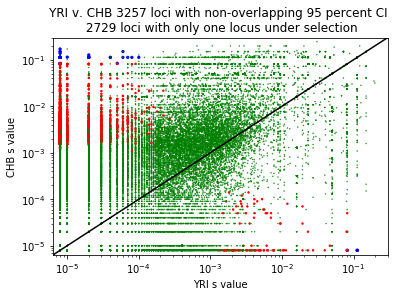

In [27]:
color_list, size_list, overlap, diff_sel, diff_score_med, diff_score_ci, diff_opt = getNumNonOverlap(conf_int_YRI, conf_int_CHB, svals_YRI, svals_CHB, pvals_YRI, pvals_CHB, opt_YRI, opt_CHB, default_color, non_default_color, default_size, non_default_size, chrom_list, start_list, top_n)
fig_num = 3
pop1 = 'YRI'
pop2 = 'CHB'
plot(color_list, size_list, overlap, diff_sel, diff_opt, svals_YRI, svals_CHB, fig_num, pop1, pop2)

In [28]:
#Write results to file YRI/CHB

df = pd.DataFrame()
df['chrom'] = chrom_list
df['start'] = start_list
df['end'] = end_list
df['period'] = per_list
df['motif'] = motif_list
df['YRI_optimal_ru'] = opt_YRI
df['CHB_optimal_ru'] = opt_CHB
df['YRI_s_val'] = svals_YRI
df['CHB_s_val'] = svals_CHB
df['YRI_95%_CI'] = conf_int_YRI
df['CHB_95%_CI'] = conf_int_CHB
df['YRI_p_val'] = pvals_YRI
df['CHB_p_val'] = pvals_CHB
df['diff_score_med'] = diff_score_med
df['diff_score_ci'] = diff_score_ci
df['ci_overlap'] = overlap
df['diff_opt'] = diff_opt
df['diff_selection'] = diff_sel
'''
df['coding'] = coding_list
df['intron'] = intron_list 
df['utr5'] = utr5_list
df['utr3'] = utr3_list 
df['promoter'] = promoter_list
df['intergenic'] = intergenic_list
'''
#df.to_csv('diff_scores_YRI_CHB_annot.txt', sep = '\t', index=False)
df.head(50)

,chrom,start,end,period,motif,YRI_optimal_ru,CHB_optimal_ru,YRI_s_val,CHB_s_val,YRI_95%_CI,CHB_95%_CI,YRI_p_val,CHB_p_val,diff_score_med,diff_score_ci,ci_overlap,diff_opt,diff_selection
0,1,44836,44868,4,AAAT,8,8,0.00199,0.00051,"(0,0.00638)","(0,0.00301)",0.002748,0.027984,0.00148,0.00000,Y,N,N
1,1,50482,50514,2,AC,16,16,0.00000,0.00016,"(0,0.00062)","(0,0.00104)",0.183923,0.053480,0.00016,0.00000,Y,N,N
2,1,144528,144576,2,AT,24,24,0.00000,0.00000,"(0,0.00058)","(0,0.00058)",1.000000,1.000000,0.00000,0.00000,Y,N,N
3,1,393782,393808,2,AC,13,13,0.00000,0.00208,"(0,0.0006)","(2e-05,0.00733)",0.306557,0.000975,0.00208,0.00000,Y,N,Y
4,1,396902,396942,2,AC,20,20,0.00000,0.00019,"(0,0.0008)","(0,0.00141)",0.176070,0.077456,0.00019,0.00000,Y,N,N
5,1,414630,414676,2,AC,23,23,0.00108,0.00563,"(0,0.00337)","(0.00282,0.01056)",0.006453,0.000082,0.00455,0.00000,Y,N,N
6,1,435605,435623,3,AGG,6,6,0.00000,0.00020,"(0,0.00714)","(0,0.24337)",1.000000,0.331951,0.00020,0.00000,Y,N,N
7,1,503139,503173,2,AT,13,12,0.00000,0.00000,"(0,0.00057)","(0,0.00086)",1.000000,1.000000,0.00000,0.00000,Y,Y,N
8,1,623672,623700,2,AC,14,14,0.00004,0.00052,"(0,0.0008)","(0,0.00256)",0.268238,0.012480,0.00048,0.00000,Y,N,N
9,1,626782,626822,2,AC,20,20,0.00002,0.00124,"(0,0.00074)","(0.00044,0.00252)",0.374374,0.018028,0.00122,0.00000,Y,N,N
